# Using adaptive retrieval on the synthetic dataset

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import pearsonr
import os

# 毎回これを実行しないと結果が変わる
seed = 633
np.random.seed(seed)
import random
random.seed(seed)

In [12]:
# take the results of parametric and nonparametric-augmented systems 
# and compute how well adaptive retrieval would perform
do_plot = True
n_boot = 100
# parametric_path = "results/temp/model=EleutherAI_gpt-neox-20b-input=None-method=vanilla-shots=15-n=1000_int8bit.csv"  # ADD PATH TO VANILLA RESULTS
# nonparametric_path = "results/temp/model=EleutherAI_gpt-neox-20b-input=None-method=BM25-shots=15-n=1000_int8bit.csv"  # ADD PATH TO RETRIEVAL-AUGMENTED RESULTS
parametric_path = "results/temp/model=EleutherAI_gpt-neox-20b-input=None-method=vanilla-shots=15-n=union1400and2000_int8bit.csv"  # ADD PATH TO VANILLA RESULTS
nonparametric_path = "results/temp/model=EleutherAI_gpt-neox-20b-input=None-method=BM25-shots=15-n=union1000and2000_int8bit.csv"  # ADD PATH TO RETRIEVAL-AUGMENTED RESULTS
def clean(df):
    return df[~df["s_pop"].isna() & (df["s_pop"] >= 0)]
sample = clean(pd.read_csv(parametric_path))
sample_ret = clean(pd.read_csv(nonparametric_path))
sample = sample.sort_values("question").reset_index(drop=True)
sample_ret = sample_ret.sort_values("question").reset_index(drop=True)
print(len(sample), len(sample_ret))

2000 2000


['place of birth' 'country' 'color' 'genre' 'capital of' 'occupation'
 'capital' 'religion' 'sport' 'author' 'father' 'mother' 'composer'
 'director' 'producer' 'screenwriter']
ser = 78
test_ser = 17
test_counts_c = 10
[ 3.13549422  3.95735183  4.77920945  5.60106707  6.42292469  7.24478231
  8.06663993  8.88849755  9.71035517 10.53221278 11.3540704 ]
[ 3.13549422  3.95735183  4.77920945  5.60106707  6.42292469  7.24478231
  8.06663993  8.88849755  9.71035517 10.53221278]
Threshold for place of birth: 8.47756873787515
Parametric knowledge only: 0.20512820512820512
Retrieval augmented accuracy: 0.5256410256410257
New accuracy with thresh=7: 0.5256410256410257

ser = 116
test_ser = 26
test_counts_c = 10
[ 2.89037176  3.68581874  4.48126572  5.2767127   6.07215968  6.86760666
  7.66305364  8.45850062  9.2539476  10.04939458 10.84484156]
[ 2.89037176  3.68581874  4.48126572  5.2767127   6.07215968  6.86760666
  7.66305364  8.45850062  9.2539476  10.04939458]
Threshold for country: 9.651671

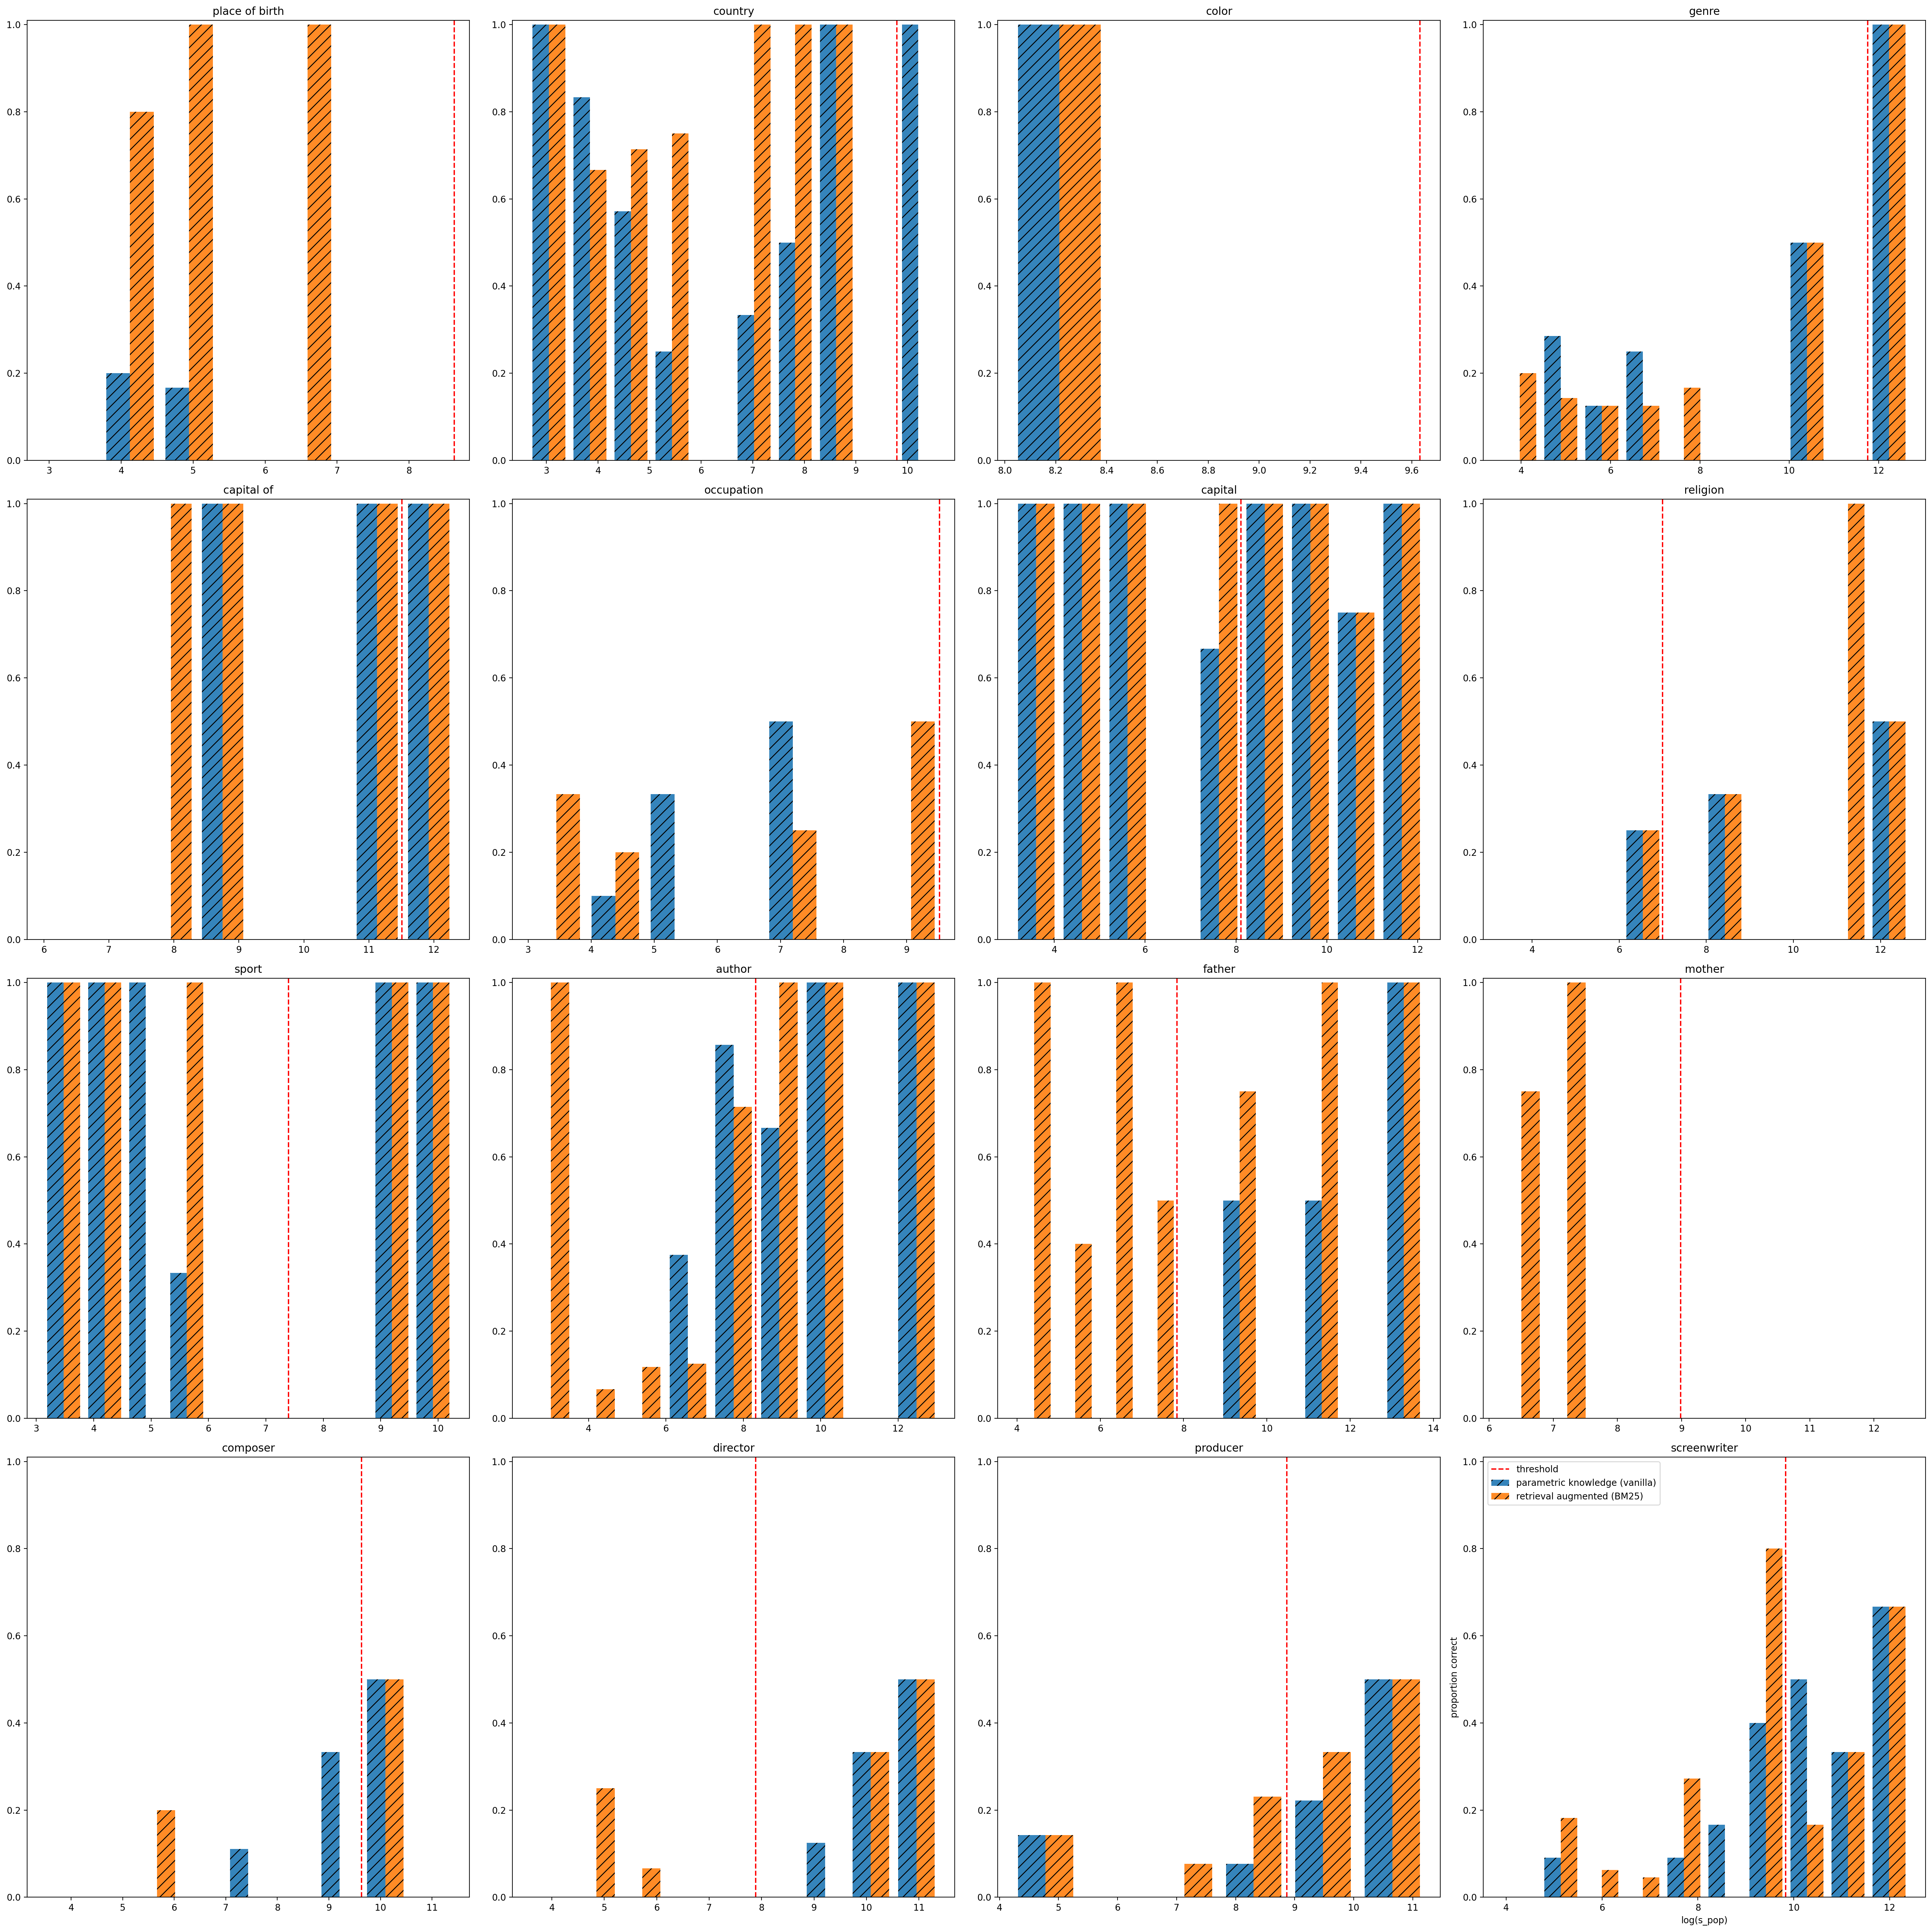

prop adaptive: 1.0
prop retrieval: 0.81
parametric knowledge only: 0.216
retrieval augmented accuracy: 0.304
hybrid accuracy: 0.3 pm 0.0
hybrid accuracy on train: 0.30933333333333335
overall accuracy gain: -0.0040000000000000036
overall accuracy: 0.3


In [ ]:
import math

# suppress warnings
import warnings
warnings.filterwarnings("ignore")
props = sample.prop.unique()

test_ret_accs_all = []
test_param_accs_all = []
test_hybrid_accs_all = []
test_count_rets = []
test_count_params = []
train_hybrid_accs_all = []

for boot in range(1 if do_plot else n_boot): # boot = 1~100
    split_proportion = 0.75
    # 結果の件数＊0.75個の"train" と 結果の件数*0.25の"test"のリスト
    split_mask = ["train"] * round(len(sample) * split_proportion) + ["test"] * round(len(sample) * (1 - split_proportion))
    np.random.shuffle(split_mask)
    # カラムを追加 各データに trainかtestを割り当てる
    sample["split"] = split_mask
    sample_ret["split"] = split_mask

    test_ret_accs = []
    test_param_accs = []
    test_hybrid_accs = []
    train_hybrid_accs = []
    test_count_rets.append(0)
    test_count_params.append(0)
    test_sizes = []
    train_sizes = []
    train_threshs = dict()
    plot_title = ""
    if do_plot:
        plt.figure(dpi=200, figsize=(30, 30))
    # 各propについて見ていく propとはrelationship typeのこと。
    print(props)
    for i, prop in enumerate(props):

        if do_plot:
            plt.subplot(4, 4, i+1)
        cluster_sample = sample[sample.prop == prop].copy()
        cluster_sample_ret_with_pop = sample_ret[sample_ret.prop == prop].copy()

        # testが0件ならランダムで1件をtrain -> testに変更
        if len(cluster_sample[cluster_sample.split == "test"]) == 0:
            # print(f'prop={prop}, test=0')
            # print(len(cluster_sample[cluster_sample.split == "train"]), len(cluster_sample_ret_with_pop[cluster_sample_ret_with_pop.split == "train"]))
            # print(len(cluster_sample[cluster_sample.split == "test"]), len(cluster_sample_ret_with_pop[cluster_sample_ret_with_pop.split == "test"]))
            index = cluster_sample[cluster_sample.split == "train"].sample().index
            cluster_sample.loc[index, "split"] = "test"
            cluster_sample_ret_with_pop.loc[index, "split"] = "test"

        # s_popの対数を出す。検索なし・ありで同じ値なのでなしの場合だけ計算すればＯＫ
        log_pop = np.log(cluster_sample["s_pop"].values)
        cluster_sample["log_pop"] = log_pop
        cluster_sample_ret_with_pop["log_pop"] = log_pop
        ser = log_pop
        _, bin_edges = np.histogram(ser) # 人気度の範囲

        # 正解・不正解の件数について、人気度をbinsにしてカウントする
        c = cluster_sample.is_correct.values
        counts_c, _ = np.histogram(ser[c], bins=bin_edges)
        counts_inc, _ = np.histogram(ser[~c], bins=bin_edges)
        total = counts_c + counts_inc

        c_ret = cluster_sample_ret_with_pop.is_correct.values
        counts_c_ret, _ = np.histogram(ser[c_ret], bins=bin_edges)
        counts_inc_ret, _ = np.histogram(ser[~c_ret], bins=bin_edges)
        total_ret = counts_c_ret + counts_inc_ret

        # binsの１区間の範囲*0.4
        width = 0.4*(bin_edges[1] - bin_edges[0])
        # 人気度の閾値を計算（最も正解数が多くなるiを採用）
        thresh_idx = np.argmax(list((sum(counts_c_ret[:i]) + sum(counts_c[i:])) / sum(total_ret) for i in range(len(total_ret) + 1)))
        # print("threshold: prop={}, pop={}".format(prop, ))

        # plt.bar(bin_edges[:-1] - 0.5 * width, counts_c / total, width=width, alpha=0.9, label="parametric knowledge (vanilla)", align='edge')
        # plt.bar(bin_edges[:-1] + 0.5 * width, counts_c_ret / total_ret, width=width, alpha=0.9, label="retrieval augmented (BM25)", align='edge')
        # lo, hi = proportion_confint(counts_c, total, alpha=0.05, method='wilson')
        # plt.errorbar(bin_edges[:-1], counts_c / total, yerr=[counts_c / total - lo, hi - counts_c / total], fmt='none', ecolor='black', elinewidth=1, capsize=2)
        # lo, hi = proportion_confint(counts_c_ret, total_ret, alpha=0.05, method='wilson')
        # plt.errorbar(bin_edges[:-1] + width, counts_c_ret / total_ret, yerr=[counts_c_ret / total_ret - lo, hi - counts_c_ret / total_ret], fmt='none', ecolor='black', elinewidth=1, capsize=2)
        # # plt.errorbar(bin_edges[:-1], counts_c / total, , fmt='none', ecolor='black', capsize=2)
        # # plt.errorbar(bin_edges[:-1], counts_c_ret / total_ret, yerr=wilson(counts_c_ret / total_ret, total_ret), fmt='none', ecolor='black', capsize=2)
        # plt.axvline(x=bin_edges[thresh_idx] + 0.7 * (bin_edges[1] - bin_edges[0]), color='red', linestyle='--', label="threshold")

        # 正解率 不要なのでコメントアウトしてもいい
        param_acc = sum(counts_c) / sum(total)
        ret_acc = sum(counts_c_ret) / sum(total_ret)
        hybrid_acc = (sum(counts_c_ret[:thresh_idx]) + sum(counts_c[thresh_idx:])) / (sum(total_ret[:thresh_idx]) + sum(total[thresh_idx:]))
        ret_acc_gain = hybrid_acc - ret_acc
        param_acc_gain = hybrid_acc - param_acc
        
        # let the optimal threshold be the one that maximizes the hybrid accuracy
        train_idxs = cluster_sample.split.values == "train"
        test_idxs = cluster_sample.split.values == "test"
        train_ser = ser[train_idxs]
        test_ser = ser[test_idxs]
        train_c = c[train_idxs]
        test_c = c[test_idxs]
        train_c_ret = c_ret[train_idxs]
        test_c_ret = c_ret[test_idxs]
        train_counts_c, _ = np.histogram(train_ser[train_c], bins=bin_edges)
        train_counts_inc, _ = np.histogram(train_ser[~train_c], bins=bin_edges)
        train_total = train_counts_c + train_counts_inc
        train_counts_c_ret, _ = np.histogram(train_ser[train_c_ret], bins=bin_edges)
        train_counts_inc_ret, _ = np.histogram(train_ser[~train_c_ret], bins=bin_edges)
        train_total_ret = train_counts_c_ret + train_counts_inc_ret
        test_counts_c, _ = np.histogram(test_ser[test_c], bins=bin_edges)
        test_counts_inc, _ = np.histogram(test_ser[~test_c], bins=bin_edges)
        test_total = test_counts_c + test_counts_inc
        test_counts_c_ret, _ = np.histogram(test_ser[test_c_ret], bins=bin_edges)
        test_counts_inc_ret, _ = np.histogram(test_ser[~test_c_ret], bins=bin_edges)
        test_total_ret = test_counts_c_ret + test_counts_inc_ret
        print("ser = {}".format(len(ser)))
        print("test_ser = {}".format(len(test_ser)))
        print("test_counts_c = {}".format(len(test_counts_c)))
        print(bin_edges)
        print(bin_edges[:-1])
        
        # find the optimal threshold
        train_thresh_idx = np.argmax(list((sum(train_counts_c_ret[:i]) + sum(train_counts_c[i:])) / (sum(train_total_ret[:i]) + sum(train_total[i:])) for i in range(len(train_total) + 1)))
        train_thresh = bin_edges[train_thresh_idx] - 0.5 * (bin_edges[1] - bin_edges[0])
        train_threshs[prop] = train_thresh

        # calculate the accuracy on the test set
        test_param_acc = sum(test_counts_c) / sum(test_total)
        test_ret_acc = sum(test_counts_c_ret) / sum(test_total_ret)
        test_hybrid_acc = (sum(test_counts_c_ret[:train_thresh_idx]) + sum(test_counts_c[train_thresh_idx:])) / (sum(test_total_ret[:train_thresh_idx]) + sum(test_total[train_thresh_idx:]))
        test_sizes.append(sum(test_total))
        test_count_rets[-1] += sum(test_total_ret[:train_thresh_idx])
        test_count_params[-1] += sum(test_total[train_thresh_idx:])
        test_ret_accs.append(test_ret_acc)
        test_param_accs.append(test_param_acc)
        test_hybrid_accs.append(test_hybrid_acc)
        train_hybrid_accs.append((sum(train_counts_c_ret[:train_thresh_idx]) + sum(train_counts_c[train_thresh_idx:])) / (sum(train_total_ret[:train_thresh_idx]) + sum(train_total[train_thresh_idx:])))
        train_sizes.append(sum(train_total))

        if do_plot:
            # テストデータでの結果をプロット
            # ブルーバー：vanilla 縦軸が正解率、横軸が人気度の対数
            plt.bar(bin_edges[:-1] - 0.5 * width, test_counts_c / test_total, width=width, alpha=0.9, label="parametric knowledge (vanilla)", align='edge', hatch='//')
            # オレンジバー：検索補強の 縦軸が正解率、横軸が人気度の対数
            plt.bar(bin_edges[:-1] + 0.5 * width, test_counts_c_ret / test_total_ret, width=width, alpha=0.9, label="retrieval augmented (BM25)", align='edge', hatch='//')
            # 信頼区間
            lo, hi = proportion_confint(test_counts_c, test_total, alpha=0.05, method='wilson')
            #plt.errorbar(bin_edges[:-1], test_counts_c / test_total, yerr=[test_counts_c / test_total - lo, hi - test_counts_c / test_total], fmt='none', ecolor='black', elinewidth=1, capsize=2)
            # 信頼区間
            lo, hi = proportion_confint(test_counts_c_ret, test_total_ret, alpha=0.05, method='wilson')
            #plt.errorbar(bin_edges[:-1] + width, test_counts_c_ret / test_total_ret, yerr=[test_counts_c_ret / test_total_ret - lo, hi - test_counts_c_ret / test_total_ret], fmt='none', ecolor='black', elinewidth=1, capsize=2)
            # 赤い点線：人気度の閾値 この線より右は青色(vanilla)、左は赤色(ret)が採用される
            plt.axvline(x=bin_edges[train_thresh_idx] - 0.8 * width, color='red', linestyle='--', label="threshold")

            print(f"Threshold for {prop}:", train_thresh)
            print("Parametric knowledge only:", param_acc)
            print("Retrieval augmented accuracy:", ret_acc)
            print(f"New accuracy with thresh={thresh_idx}:", hybrid_acc)
            print()
            plt.title(f"{prop}")
            plt.ylim([0,1.01])
    if do_plot:
        plt.xlabel("log(s_pop)")
        plt.ylabel("proportion correct")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # take the weighted mean by test_size
    test_ret_accs_all.append(np.average(test_ret_accs, weights=test_sizes))
    test_param_accs_all.append(np.average(test_param_accs, weights=test_sizes))
    test_hybrid_accs_all.append(np.average(test_hybrid_accs, weights=test_sizes))
    train_hybrid_accs_all.append(np.average(train_hybrid_accs, weights=train_sizes))

test_size = split_mask.count("test")
prop_adaptive = (np.mean(test_count_rets) + np.mean(test_count_params)) / test_size
param_acc = np.mean(test_param_accs_all)
# print(test_param_accs_all)
# print(len(test_param_accs_all))
ret_acc = np.mean(test_ret_accs_all)
hybrid_acc = np.mean(test_hybrid_accs_all)
train_hybrid_acc = np.mean(train_hybrid_accs_all)
overall_hybrid_acc = np.mean(test_hybrid_accs_all) * prop_adaptive + max(np.mean(test_param_accs_all), np.mean(test_ret_accs_all)) * (1 - prop_adaptive)
sem_test_hybrid_acc = 2 * np.std(test_hybrid_accs_all) / np.sqrt(test_size)
print("prop adaptive:", prop_adaptive)
print("prop retrieval:", np.mean(test_count_rets) / test_size)
print("parametric knowledge only:", param_acc)
print("retrieval augmented accuracy:", ret_acc)
print("hybrid accuracy:", hybrid_acc, "pm", sem_test_hybrid_acc)
print("hybrid accuracy on train:", train_hybrid_acc)
print("overall accuracy gain:", overall_hybrid_acc - max(param_acc, ret_acc))
print("overall accuracy:", overall_hybrid_acc)

# memo

## original
prop adaptive: 1.0

prop retrieval: 0.7981889543033361

parametric knowledge only: 0.17163442668909443

retrieval augmented accuracy: 0.2537706756377908

hybrid accuracy: 0.2706980656013457 pm 0.000232407510793975

hybrid accuracy on train: 0.2719317757009346

overall accuracy gain: 0.016927389963554862

overall accuracy: 0.2706980656013457

## gpt-neox-20b
prop adaptive: 1.0

prop retrieval: 0.82366

parametric knowledge only: 0.20631325301204817

retrieval augmented accuracy: 0.29742168674698793

hybrid accuracy: 0.29325301204819276 pm 0.0014398690284143172

hybrid accuracy on train: 0.3114733333333334

overall accuracy gain: -0.004168674698795172

overall accuracy: 0.29325301204819276

# 考察用にデータセット全てでAdaptive-Retrievalを試す

- 仮に訓練で人気度の閾値を最適な値にできたとしたらどうなるか

['place of birth' 'country' 'color' 'genre' 'capital of' 'occupation'
 'capital' 'religion' 'sport' 'author' 'father' 'mother' 'composer'
 'director' 'producer' 'screenwriter']
prop=place of birth, threshold_pop=8.88849754725561, 9.463797880388256
param_acc=0.20512820512820512, ret_acc=0.5256410256410257, hybrid_acc=0.5256410256410257

prop=country, threshold_pop=10.049394579793173, 10.606207465940718
param_acc=0.5689655172413793, ret_acc=0.7155172413793104, hybrid_acc=0.7241379310344828

prop=color, threshold_pop=9.763008429849444, 10.048259866820965
param_acc=0.7142857142857143, ret_acc=0.8571428571428571, hybrid_acc=0.8571428571428571

prop=genre, threshold_pop=12.048384562369678, 12.691155279027011
param_acc=0.09090909090909091, ret_acc=0.14354066985645933, hybrid_acc=0.14354066985645933

prop=capital of, threshold_pop=11.761856825292991, 12.31694780400478
param_acc=0.29411764705882354, ret_acc=0.43137254901960786, hybrid_acc=0.43137254901960786

prop=occupation, threshold_pop=9.81

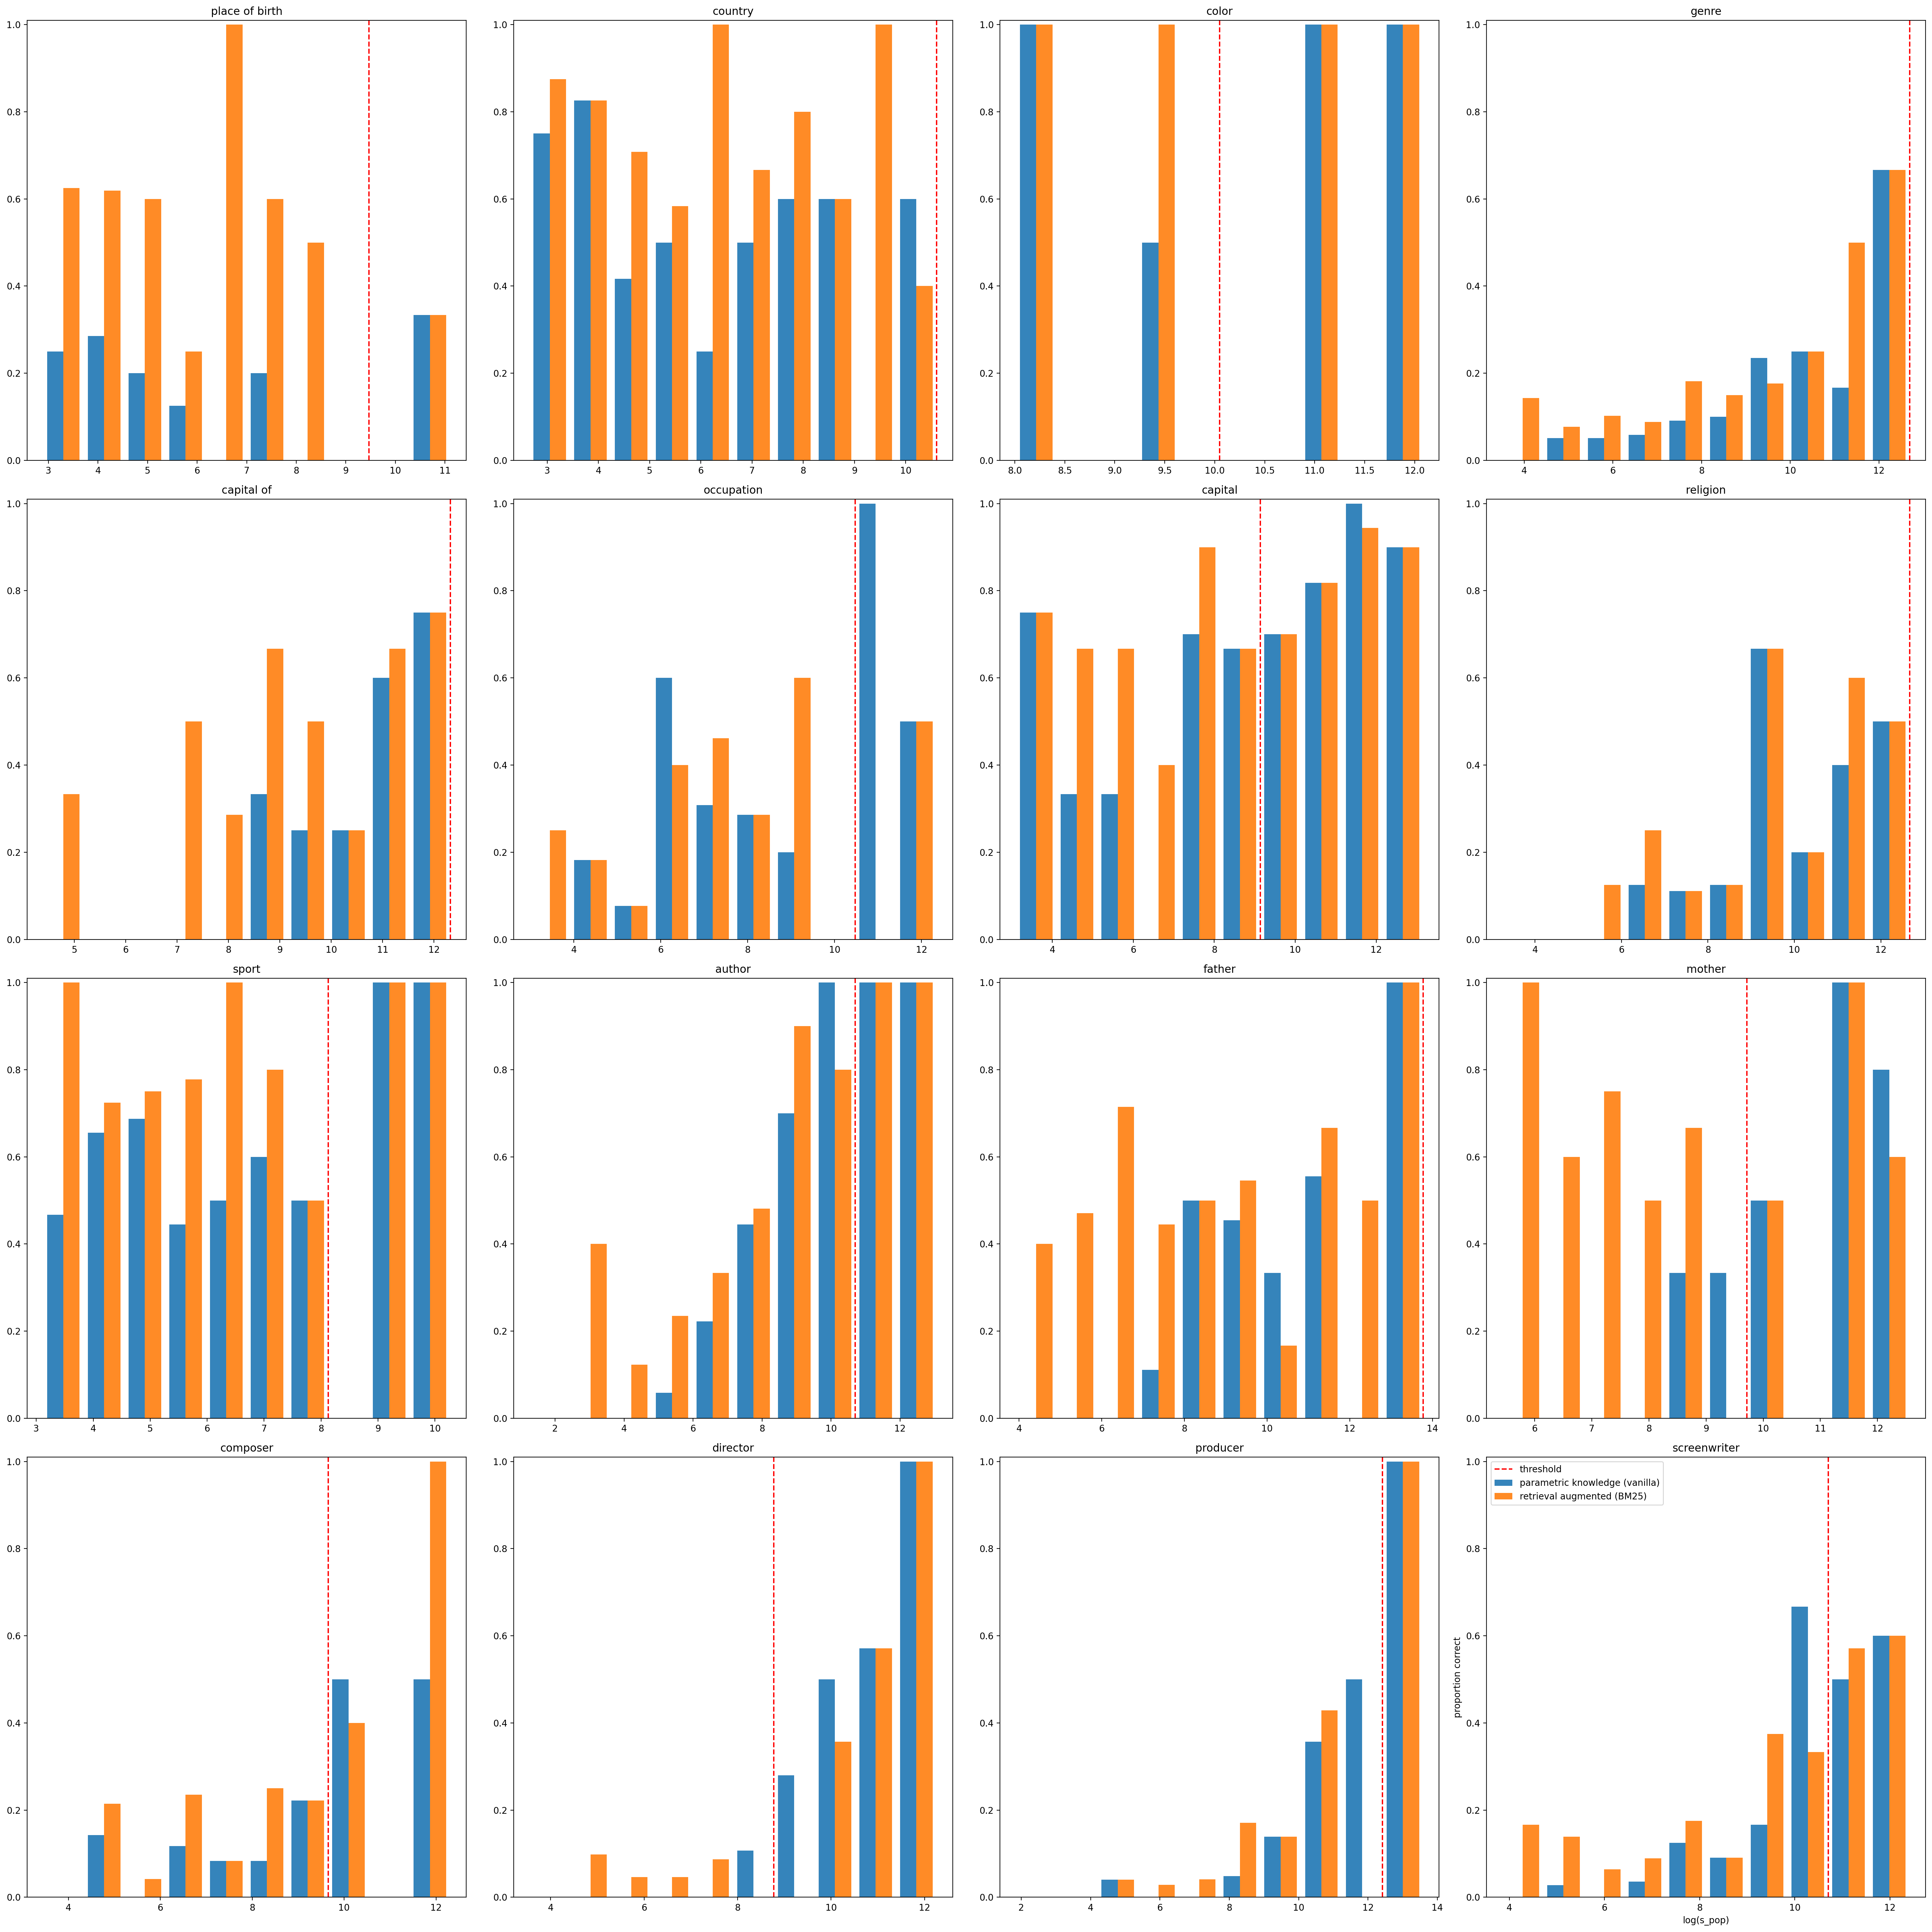

prop adaptive: 4.0
prop retrieval: 3.49
parametric knowledge only: 0.208
retrieval augmented accuracy: 0.298
hybrid accuracy: 0.31 pm 0.0
hybrid accuracy on train: 0.31
overall accuracy gain: 0.0480000000000001
overall accuracy: 0.3460000000000001


In [20]:
import math

# suppress warnings
import warnings
warnings.filterwarnings("ignore")
props = sample.prop.unique()

test_ret_accs_all = []
test_param_accs_all = []
test_hybrid_accs_all = []
test_count_rets = []
test_count_params = []
train_hybrid_accs_all = []


test_ret_accs = []
test_param_accs = []
test_hybrid_accs = []
train_hybrid_accs = []
test_count_rets.append(0)
test_count_params.append(0)
test_sizes = []
train_sizes = []
train_threshs = dict()
plot_title = ""
if do_plot:
    plt.figure(dpi=200, figsize=(30, 30))
# 各propについて見ていく propとはrelationship typeのこと。
print(props)

result_df = pd.DataFrame()
test_threshold_pop = []

for i, prop in enumerate(props):

    if do_plot:
        plt.subplot(4, 4, i+1)
    cluster_sample = sample[sample.prop == prop].copy()
    cluster_sample_ret_with_pop = sample_ret[sample_ret.prop == prop].copy()

    # s_popの対数を出す。検索なし・ありで同じ値なのでなしの場合だけ計算すればＯＫ
    log_pop = np.log(cluster_sample["s_pop"].values)
    cluster_sample["log_pop"] = log_pop
    cluster_sample_ret_with_pop["log_pop"] = log_pop
    ser = log_pop
    _, bin_edges = np.histogram(ser) # 人気度の範囲

    # 正解・不正解の件数について、人気度をbinsにしてカウントする
    c = cluster_sample.is_correct.values
    counts_c, _ = np.histogram(ser[c], bins=bin_edges)
    counts_inc, _ = np.histogram(ser[~c], bins=bin_edges)
    total = counts_c + counts_inc

    c_ret = cluster_sample_ret_with_pop.is_correct.values
    counts_c_ret, _ = np.histogram(ser[c_ret], bins=bin_edges)
    counts_inc_ret, _ = np.histogram(ser[~c_ret], bins=bin_edges)
    total_ret = counts_c_ret + counts_inc_ret

    # binsの１区間の範囲*0.4
    width = 0.4*(bin_edges[1] - bin_edges[0])
    # 人気度の閾値を計算（最も正解数が多くなるiを採用）
    thresh_idx = np.argmax(list((sum(counts_c_ret[:i]) + sum(counts_c[i:])) / sum(total_ret) for i in range(len(total_ret) + 1)))

    plt.bar(bin_edges[:-1] - 0.5 * width, counts_c / total, width=width, alpha=0.9, label="parametric knowledge (vanilla)", align='edge')
    plt.bar(bin_edges[:-1] + 0.5 * width, counts_c_ret / total_ret, width=width, alpha=0.9, label="retrieval augmented (BM25)", align='edge')
    lo, hi = proportion_confint(counts_c, total, alpha=0.05, method='wilson')
    # plt.errorbar(bin_edges[:-1], counts_c / total, yerr=[counts_c / total - lo, hi - counts_c / total], fmt='none', ecolor='black', elinewidth=1, capsize=2)
    lo, hi = proportion_confint(counts_c_ret, total_ret, alpha=0.05, method='wilson')
    # plt.errorbar(bin_edges[:-1] + width, counts_c_ret / total_ret, yerr=[counts_c_ret / total_ret - lo, hi - counts_c_ret / total_ret], fmt='none', ecolor='black', elinewidth=1, capsize=2)
    # plt.errorbar(bin_edges[:-1], counts_c / total, , fmt='none', ecolor='black', capsize=2)
    # plt.errorbar(bin_edges[:-1], counts_c_ret / total_ret, yerr=wilson(counts_c_ret / total_ret, total_ret), fmt='none', ecolor='black', capsize=2)
    plt.axvline(x=bin_edges[thresh_idx] + 0.7 * (bin_edges[1] - bin_edges[0]), color='red', linestyle='--', label="threshold")
    plt.title(f"{prop}")
    plt.ylim([0,1.01])

    # 正解率
    param_acc = sum(counts_c) / sum(total)
    ret_acc = sum(counts_c_ret) / sum(total_ret)
    hybrid_acc = (sum(counts_c_ret[:thresh_idx]) + sum(counts_c[thresh_idx:])) / (sum(total_ret[:thresh_idx]) + sum(total[thresh_idx:]))
    ret_acc_gain = hybrid_acc - ret_acc
    param_acc_gain = hybrid_acc - param_acc
    print("prop={}, threshold_pop={}, {}".format(prop, bin_edges[thresh_idx], bin_edges[thresh_idx] + 0.7 * (bin_edges[1] - bin_edges[0])))
    print(f"param_acc={param_acc}, ret_acc={ret_acc}, hybrid_acc={hybrid_acc}")
    # print(f"param_acc_gain={param_acc_gain}")
    # print(f"ret_acc_gain={ret_acc_gain}")
    print("")
    test_sizes.append(sum(total))
    test_count_rets[-1] += sum(total_ret[:thresh_idx])
    test_count_params[-1] += sum(total[thresh_idx:])
    test_ret_accs.append(ret_acc)
    test_param_accs.append(param_acc)
    test_hybrid_accs.append(hybrid_acc)
    train_hybrid_accs.append(hybrid_acc)
    train_sizes.append(sum(total_ret))
    test_threshold_pop.append(bin_edges[thresh_idx])

if do_plot:
    plt.xlabel("log(s_pop)")
    plt.ylabel("proportion correct")
    plt.legend()
    plt.tight_layout()
    plt.show()

# take the weighted mean by test_size
test_ret_accs_all.append(np.average(test_ret_accs, weights=test_sizes))
test_param_accs_all.append(np.average(test_param_accs, weights=test_sizes))
test_hybrid_accs_all.append(np.average(test_hybrid_accs, weights=test_sizes))
train_hybrid_accs_all.append(np.average(train_hybrid_accs, weights=train_sizes))

test_size = split_mask.count("test")
prop_adaptive = (np.mean(test_count_rets) + np.mean(test_count_params)) / test_size
param_acc = np.mean(test_param_accs_all)
ret_acc = np.mean(test_ret_accs_all)
hybrid_acc = np.mean(test_hybrid_accs_all)
train_hybrid_acc = np.mean(train_hybrid_accs_all)
overall_hybrid_acc = np.mean(test_hybrid_accs_all) * prop_adaptive + max(np.mean(test_param_accs_all), np.mean(test_ret_accs_all)) * (1 - prop_adaptive)
sem_test_hybrid_acc = 2 * np.std(test_hybrid_accs_all) / np.sqrt(test_size)
print("prop adaptive:", prop_adaptive)
print("prop retrieval:", np.mean(test_count_rets) / test_size)
print("parametric knowledge only:", param_acc)
print("retrieval augmented accuracy:", ret_acc)
print("hybrid accuracy:", hybrid_acc, "pm", sem_test_hybrid_acc)
print("hybrid accuracy on train:", train_hybrid_acc)
print("overall accuracy gain:", overall_hybrid_acc - max(param_acc, ret_acc))
print("overall accuracy:", overall_hybrid_acc)

result_df["prop"] = props
result_df["thresnold"] = test_threshold_pop
result_df["param_acc"] = test_param_accs
result_df["ret_acc"] = ret_acc
result_df["hybrid_acc"] = test_hybrid_accs
result_df.to_csv("results/discussion/model=EleutherAI_gpt-neox-20b-input=None-shots=15-n=union1400and2000_int8bit-ar_summary.csv")